In [1]:
import numpy as np
import sympy as sp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import itertools

In [2]:
def plot_phase_portrait(f, ax=None, figsize=(3, 3), plot_equilibria=True):
    xs = np.linspace(-2, 2, 11)
    us = np.linspace(-2, 2, 11)

    xss, uss = np.meshgrid(xs, us)
    dxss, duss = f(xss, uss)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    # Plot the quiver plot
    ax.quiver(xss, uss, dxss, duss)

    # Try to plot the equilibria
    if plot_equilibria:
        # Create some sympy symbols
        x, u = sp.symbols('x u')

        # Compute the Jacobian elements
        dfx_dx = sp.diff(f(x, u)[0], x)
        dfx_du = sp.diff(f(x, u)[0], u)
        dfu_dx = sp.diff(f(x, u)[1], x)
        dfu_du = sp.diff(f(x, u)[1], u)

        # Plot the equilibria
        xs = np.linspace(-2, 2, 100)
        us = np.linspace(-2, 2, 100)

        sols_dict = sp.solve(f(x, u), (x, u))
        if not isinstance(sols_dict, dict):
            sols_dict = {}
            for var_ in (x, u):
                sol = sp.solve(f(x, u), var_)
                if len(sol) > 0:
                    if isinstance(sol, dict):
                        sols_dict[var_] = sol[var_]
                    else:
                        sols_dict[var_] = list(itertools.chain.from_iterable(sol))

        for var_, sols in sols_dict.items():
            if not hasattr(sols, '__iter__'):
                sols = [sols]
            for sol in sols:
                if var_ is x:
                    f_sol = sp.utilities.lambdify(u, sol, "numpy")
                    f_xs = f_sol(us) * np.ones_like(us)
                    f_us = us
                elif var_ is u:
                    f_sol = sp.utilities.lambdify(x, sol, "numpy")
                    f_us = f_sol(xs) * np.ones_like(xs)
                    f_xs = xs
                else:
                    raise ValueError("Unknown variable")

                # Differentiate between stable and unstable attractors
                f_us_stable, f_xs_stable = np.copy(f_us), np.copy(f_xs)
                f_us_unstable, f_xs_unstable = np.copy(f_us), np.copy(f_xs)

                for i, (uv, xv) in enumerate(zip(f_us, f_xs)):
                    if np.isnan(uv) or np.isnan(xv):
                        continue
                    J = np.array([
                        [dfx_dx.subs({u: uv, x: xv}).evalf(),
                         dfx_du.subs({u: uv, x: xv}).evalf()],
                        [dfu_dx.subs({u: uv, x: xv}).evalf(),
                         dfu_du.subs({u: uv, x: xv}).evalf()],
                    ], dtype=np.float)
                    if any(np.real(np.linalg.eigvals(J)) > 0):
                        f_us_stable[i] = np.NaN
                        f_xs_stable[i] = np.NaN
                    else:
                        f_us_unstable[i] = np.NaN
                        f_xs_unstable[i] = np.NaN
                cmap = cm.get_cmap('tab10')
                ax.plot(f_xs_stable, f_us_stable, color=cmap(0.0), linestyle='-', linewidth=2)
                ax.plot(f_xs_unstable, f_us_unstable, color=cmap(0.0), linestyle=':', linewidth=2)

    ax.set_xlabel("State $x$")
    ax.set_ylabel("Input $u$")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    return fig, ax

<string>:2: RuntimeWarning: invalid value encountered in sqrt
<string>:2: RuntimeWarning: invalid value encountered in sqrt


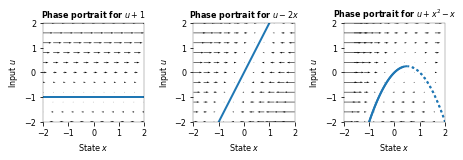

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.33))

_, ax = plot_phase_portrait(lambda x, u: (u + 1, 0), axs[0])
ax.set_title('Phase portrait for $u + 1$')

_, ax = plot_phase_portrait(lambda x, u: (u - 2 * x, 0), axs[1])
ax.set_title('Phase portrait for $u - 2x$')

_, ax = plot_phase_portrait(lambda x, u: (u + x ** 2 - x, 0), axs[2])
ax.set_title('Phase portrait for $u + x^2 - x$')

fig.tight_layout()
fig.savefig('../phase_portraits.pdf', transparent=True, bbox_inches='tight')